# Country Level Attraction Model

This notebook is used to generate a country level attraction model that can be used to assess the relative "attractiveness" of safe haven countries to refugees in the case of a forced migration event such as conflict or natural disaster.

After testing various functional forms and features, the model ultimately looks like:

```
total_refugees = b1*GDP + b2*liberal_democracy
```

where `b1` is a coefficient term for GDP and `b2` that of liberal democracy score.

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from fuzzywuzzy import process
import statsmodels.api as sm

## Data Preparation

First we load the refugee dataset which was curated from UNHCR and other sources. We can exclude data on Russia for the time being since it isn't considered as a haven country:

In [2]:
data=pd.read_csv('refugee_data/refugee_data_final.csv')
data = data[data['country']!='Russian Federation']

conflicts = '\n\t - '.join(data.conflict.unique())
print(f"This dataset contains refugee data on the following conflicts:\n\t - {conflicts}")

This dataset contains refugee data on the following conflicts:
	 - Afghanistan
	 - Burundi
	 - Central African Republic
	 - Democratic Republic of the Congo
	 - Somalia
	 - South Sudan
	 - Syria
	 - Ukraine
	 - Venezuela
	 - Nigeria


This dataset includes the `country` where refugees went `individualPerCountry` which contains the total refugees who went to `country` from the `conflict`. It also has a number of features we can try to use to model drivers of refugee migration:

In [3]:
data.head()

,country,conflict,individualPerCountry,conflict_start_year,export_trade_share,migrant_ratio,same_language,touching,Total_pop_left_conflict_zone,population,...,Afghanistan,Burundi,Central African Republic,Democratic Republic of the Congo,Nigeria,Somalia,South Sudan,Syria,Ukraine,Venezuela
0,Iran,Afghanistan,780000,2001,1.73,3.2,0,1,2238800,83183741,...,1,0,0,0,0,0,0,0,0,0
1,Pakistan,Afghanistan,1448100,2001,34.31,1.5,0,1,2238800,226992332,...,1,0,0,0,0,0,0,0,0,0
2,Tajikistan,Afghanistan,10700,2001,0.58,2.9,0,1,2238800,9537645,...,1,0,0,0,0,0,0,0,0,0
3,Uzbekistan,Afghanistan,50,2001,0.24,3.5,0,1,2238800,35300000,...,1,0,0,0,0,0,0,0,0,0
4,Turkmenistan,Afghanistan,50,2001,0.11,3.3,0,1,2238800,6031187,...,1,0,0,0,0,0,0,0,0,0


Next, we load in and process the liberal democracy index and access to justic for women from [V-Dem](https://www.v-dem.net/).

A key step is looking up V-Dem values for each country during the year **_preceding_** the conflict since this will best represent the initial conditions under which refugees made decisions.

In [4]:
def get_vdem(row):
    """
    For a given row in `data`, find the matching country from V-Dem and get the 2 relevant features
    time lagged by 1 year.
    """
    
    # find the relevant country in V-Dem using a fuzzy match
    country = process.extractOne(row.country, country_dem.country_name.unique())[0]
    
    # find the relevant liberal democracy index
    vdem_match = country_dem.loc[(country_dem["country_name"]==country) & \
                                 (country_dem["year"]==int(row['conflict_start_year']-1))]
    
    # set data's features to the found matches
    row['v2x_libdem'] = vdem_match['v2x_libdem'].iloc[0]
    row['v2xeg_eqdr'] = vdem_match['v2xeg_eqdr'].iloc[0]
    return row

country_dem=pd.read_csv('refugee_data/country_dem.csv')
data = data.apply(lambda row: get_vdem(row), axis=1)
data[['v2xeg_eqdr',"v2x_libdem",'country',"conflict_start_year"]].tail()

,v2xeg_eqdr,v2x_libdem,country,conflict_start_year
58,0.697,0.563,Panama,2014
59,0.382,0.673,Peru,2014
60,0.295,0.504,Niger,2014
61,0.406,0.158,Cameroon,2014
62,0.228,0.097,Chad,2014


Next, we read in historic GDP and get values for haven countries with a similar `t-1` year lag as with V-Dem indices.

In [5]:
def get_gdp(row):
    """
    For a given row in `data`, find the matching country from the historic GDP data and return it,
    time lagged by 1 year from the conflict year.
    """
    
    # fuzzy match the `data` country to the country name in the GDP dataset
    country = process.extractOne(row.country, historic_GDP["Country Name"].unique())[0]
    year = row.conflict_start_year - 1
    
    # if year is out of bounds (greater than 2020) just use 2020
    if year > 2020:
        year = 2020
    
    # Get GDP for the conflict year - 1
    gdp = historic_GDP[historic_GDP['Country Name']==country][str(year)].iloc[0]
    row['historic_GDP'] = gdp
    return row

historic_GDP=pd.read_csv('refugee_data/GDP_historic.csv')
data = data.apply(lambda row: get_gdp(row), axis=1)
data[['historic_GDP','country',"conflict_start_year"]].tail()

,historic_GDP,country,conflict_start_year
58,4.559999e+10,Panama,2014
59,2.011755e+11,Peru,2014
60,1.022490e+10,Niger,2014
61,3.372862e+10,Cameroon,2014
62,1.295354e+10,Chad,2014


## Featurization and Normalization

Next we calculate various features that will be relevant to our model training. These include:

- `pct_tot`: total percentage of people from `conflict A` who went to `country Z`
- `bilateral_migration_percap`: the amount of bilateral migration (from `conflict A` to `country Z`) per capita (with respect to `country Z` population)
- `gpd_per_cap`: per capita GDP for `country Z`
- `migrants_per_cap`: total migrants per capita for `country Z`

We then scale these using a [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) which normalizes them to between 0 and 1 on a **_per conflict basis_**. 

In [6]:
data['pct_tot'] = data['individualPerCountry'] / data.groupby('conflict')['individualPerCountry'].transform('sum')
data['bilateral_migration_percap'] = data['bilateral_migration']/data['population']
data['gdp_per_cap'] = data['gdp_millions']*1000000/data['population']
data['migrants_per_cap'] = data['total_recored_migrants']/data['population']

Normalizing within each conflict is crucial since it facilitates comparision of haven countries for a given conflict and reduces the model's tendency to compare grossly across all conflicts.

For example, imagine two conflicts: one in Western Europe and one in Latin America. The potential haven countries in Western Europe will _all be wealthier_ than those in Latin America (generally speaking). Therefore, normalizing _across_ these conflicts would lead to very low normalized GDPs for all Latin American havens and reduce the model's explanatory power.

Instead, we perform `0 to 1` normalization for all possible haven countries with respect to each conflict so that Latin American countries (in this example) are only normalized relative to their neighbors.

In [7]:
cols_to_scale = ['bilateral_migration','historic_GDP','gdp_millions','population', 'remittances']
scaler = MinMaxScaler()
for col in cols_to_scale:
    print(f"Normalizing column: {col}")
    normed = pd.DataFrame()
    
    for y, x in data.groupby('conflict'):
        norm_ = [i[0] for i in scaler.fit_transform(x[col].values.reshape(-1,1))]
        countries = x['country']
        conflict_ = x['conflict']
        res = pd.DataFrame(tuple(zip(countries,conflict_,norm_)), columns=['country','conflict',f"{col}_norm"])
#         normed = normed.append(res)
        normed = pd.concat([normed, res])
    data = pd.merge(data, normed, left_on=['country','conflict'], right_on=['country','conflict'], how='right')

Normalizing column: bilateral_migration
Normalizing column: historic_GDP
Normalizing column: gdp_millions
Normalizing column: population
Normalizing column: remittances


## Preparing for modeling

Next, we remove the Ukraine conflict and its corresponding countries from the dataset so that we can exclude them from model training.

First we create a dataframe of just Ukraine conflict:

In [8]:
ukr = data[data.conflict=='Ukraine'].copy(deep=True)

Next, we create a dataframe without Ukraine to train the model:

In [9]:
withoutUkrainData=data[(data["Ukraine"]!=1) & (data['touching']==1)]

We define the dependant variable as `pct_tot`: the total percentage of refugees from the conflict who went to each country. This provides a mechanism of normalizing refugee counts _across_ conflicts since really we only care about predicting refugee _shares_, not total number of refugees at this point:

In [10]:
y=withoutUkrainData['pct_tot']

Here, we are able to set independant variables for modeling. We choose only `historic_GDP_norm` (within conflict normalized GDP) and `v2x_libdem` (which is not normalized since it is already an index).

Other features were tested; they can simply be added to the array below to try additional features with the model.

In [11]:
features_cols = [
                    'historic_GDP_norm', 
                    'v2x_libdem',
                ]
features_normalized = withoutUkrainData[features_cols]

## Modeling

Finally, we are able to run the model itself. We run a multiple regression using Statsmodels:

In [12]:
results=sm.OLS(y,features_normalized.astype(float)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                pct_tot   R-squared (uncentered):                   0.600
Model:                            OLS   Adj. R-squared (uncentered):              0.579
Method:                 Least Squares   F-statistic:                              28.49
Date:                Tue, 10 May 2022   Prob (F-statistic):                    2.76e-08
Time:                        13:14:51   Log-Likelihood:                          12.594
No. Observations:                  40   AIC:                                     -21.19
Df Residuals:                      38   BIC:                                     -17.81
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
historic_GDP_norm     0.2659      0.071      3.752      0.001       0.122       0.409
v2x_libdem            0.3802      0.138      2.758      0.009       0.101       0.659
==============================================================================
Omnibus:                        4.371   Durbin-Watson:                   2.276
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                3.539
Skew:                          -0.359   Prob(JB):                        0.170
Kurtosis:                       4.268   Cond. No.                         2.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here we can see that our two features are statistically significant and explain a large portion of the variation within the dependent variable (refugee share).

In [13]:
#generate residuals from model for all countries except ukraine
residual_features_to_predict = withoutUkrainData[features_cols]
residuals = results.predict(residual_features_to_predict)
residuals = withoutUkrainData['pct_tot'] - residuals

## Backcasting Ukraine

Now we are ready to produce a forecast for Ukraine.

In [14]:
# get refugee shares prediction for Ukraine
features_to_predict=ukr[features_cols]
shares = results.predict(features_to_predict)
shares = shares / shares.sum() #normalize output results

# add them to Ukraine dataframe
ukr['predicted_shares'] = shares
ukr_results = ukr[['country','pct_tot','predicted_shares']]

# save the results
ukr_results.to_csv('outputs/ukraine_model_results.csv',index=False)
ukr_results.head()

,country,pct_tot,predicted_shares
46,Hungary,0.094222,0.133276
47,Moldova,0.093682,0.153455
48,Poland,0.586410,0.277578
49,Romania,0.154561,0.231372
50,Slovakia,0.071125,0.204320


Finally, we can pickle the model for future use:

In [15]:
results.save("outputs/attraction_model.pickle")

## Exploring the Data Visually

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
sns.set_context('talk')

For mere curiosity, we'll look at the total refugees per conflict in the entire dataset.

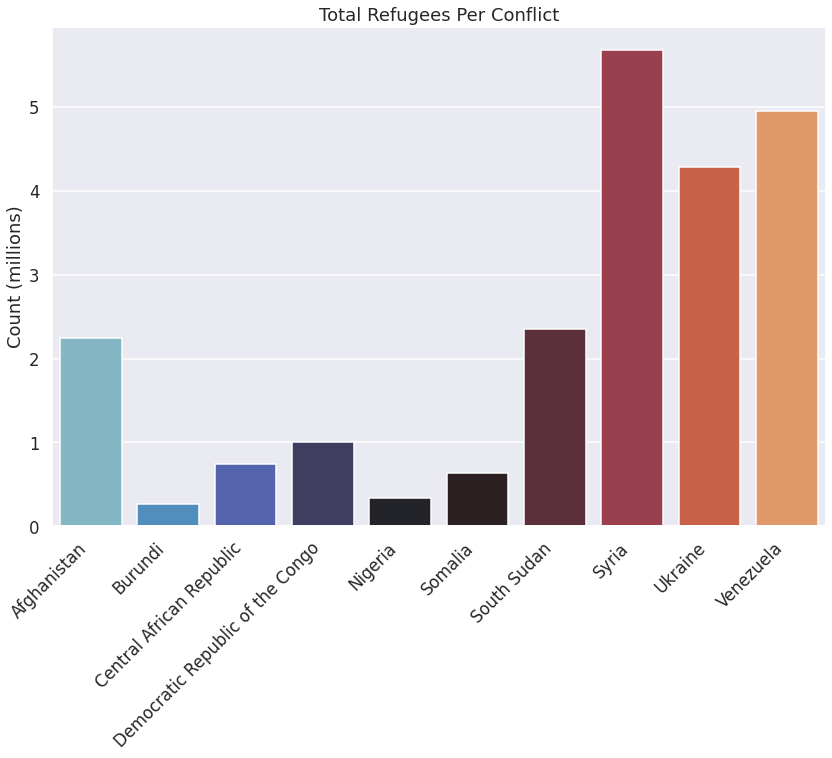

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
plt.tight_layout()

sns.barplot(x=data.groupby('conflict').sum().index, y=data.groupby('conflict').sum()['individualPerCountry']/1000000, palette='icefire', ci=None)
ax.set_ylabel('Count (millions)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Total Refugees Per Conflict')
ax.set_xlabel(None);

Now we'll examine the model and the variables themselves.

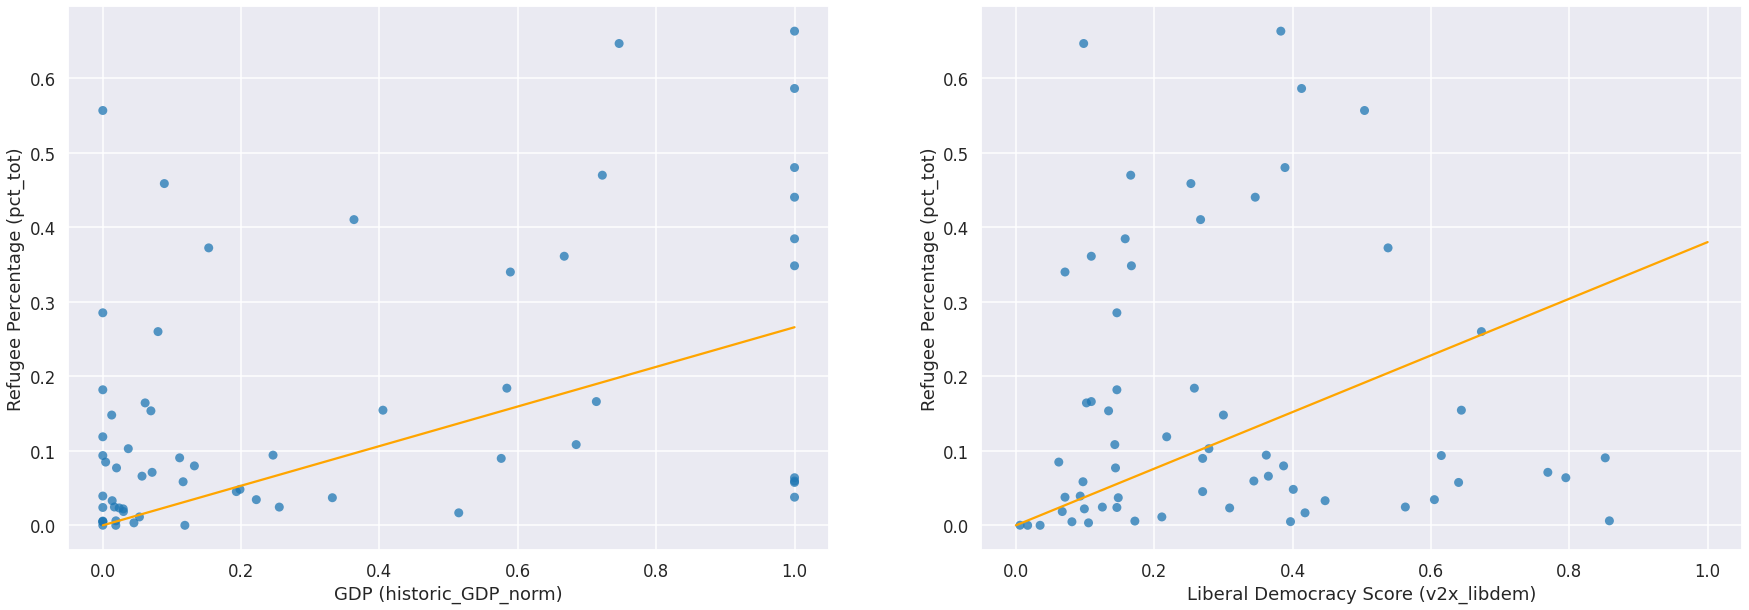

In [18]:
fig, (ax1, ax2) = plt.subplots(figsize=(30, 10), ncols=2)
sns.scatterplot(x=data['historic_GDP_norm'], y=data['pct_tot'], alpha=.75, edgecolor='none', ax=ax1)
sns.lineplot(x=np.linspace(0, 1, 2), y=np.linspace(0, 1, 2)*results.params[0], color='orange', ax=ax1)
ax1.set_ylabel('Refugee Percentage (pct_tot)')
ax1.set_xlabel('GDP (historic_GDP_norm)')

sns.scatterplot(x=data['v2x_libdem'], y=data['pct_tot'], alpha=.75, edgecolor='none', ax=ax2)
sns.lineplot(x=np.linspace(0, 1, 2), y=np.linspace(0, 1, 2)*results.params[1], color='orange', ax=ax2)
ax2.set_ylabel('Refugee Percentage (pct_tot)')
ax2.set_xlabel('Liberal Democracy Score (v2x_libdem)');

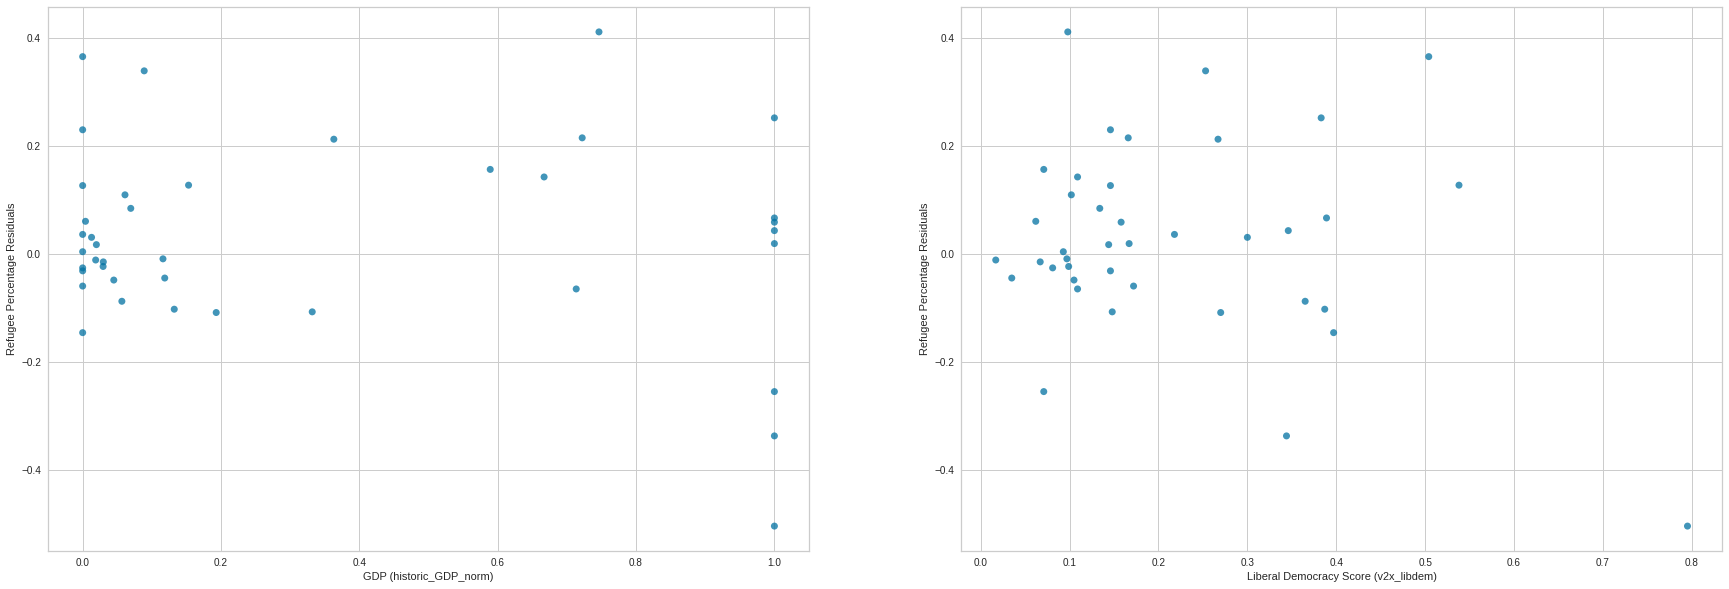

In [47]:
#plotting residuals
fig, (ax1, ax2) = plt.subplots(figsize=(30, 10), ncols=2)
sns.scatterplot(x=data['historic_GDP_norm'], y=residuals, alpha=.75, edgecolor='none', ax=ax1)
ax1.set_ylabel('Refugee Percentage Residuals')
ax1.set_xlabel('GDP (historic_GDP_norm)')

sns.scatterplot(x=data['v2x_libdem'], y=residuals, alpha=.75, edgecolor='none', ax=ax2)
ax2.set_ylabel('Refugee Percentage Residuals')
ax2.set_xlabel('Liberal Democracy Score (v2x_libdem)');

eval_env: 1
eval_env: 1


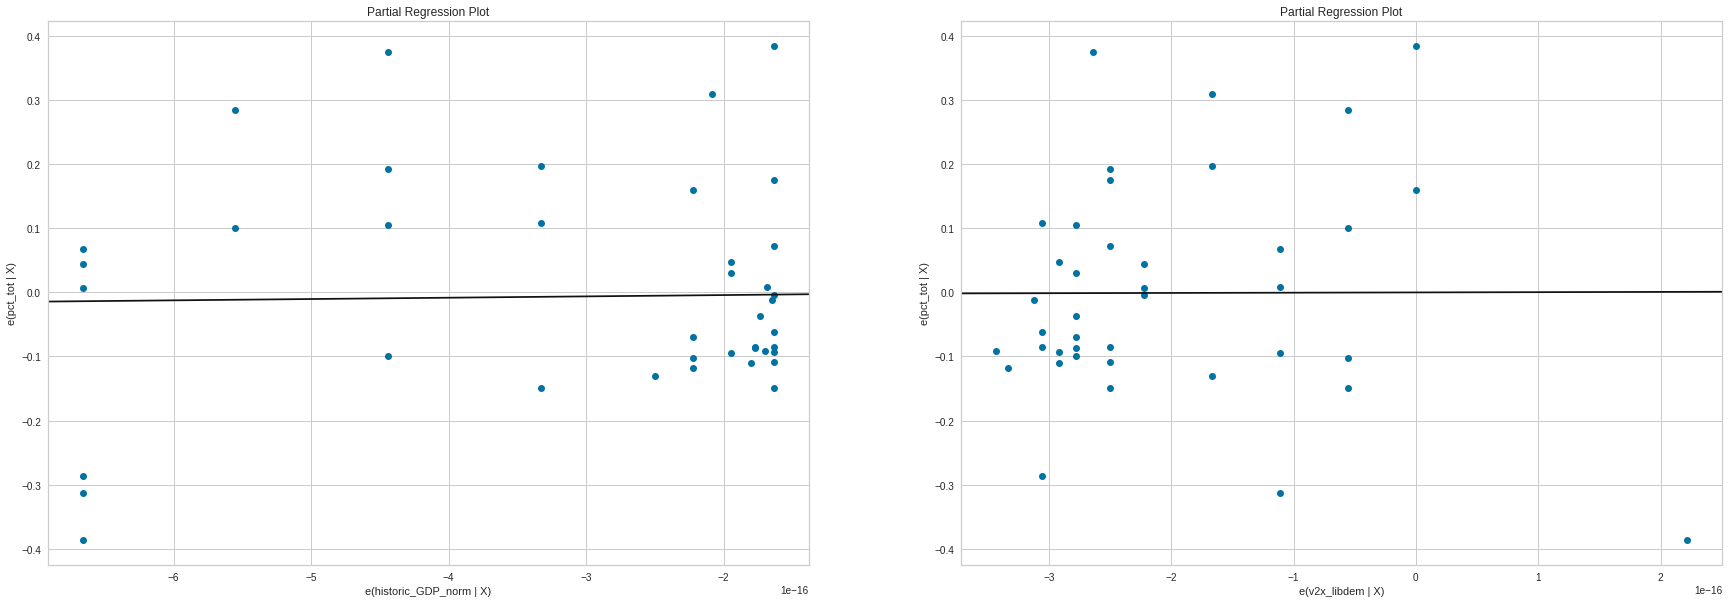

In [48]:
#partial regression plots
fig, (ax1, ax2) = plt.subplots(figsize=(30, 10), ncols=2)
fig = sm.graphics.plot_partregress(
    "pct_tot", "historic_GDP_norm", 
    ["historic_GDP_norm", "v2x_libdem"], 
    data=withoutUkrainData,
    obs_labels=False,
    ax=ax1
)
fig = sm.graphics.plot_partregress(
    "pct_tot", "v2x_libdem", 
    ["historic_GDP_norm", "v2x_libdem"], 
    data=withoutUkrainData,
    obs_labels=False,
    ax=ax2,
)

We'll also visualize the model's performance in its Ukrainian refugee predictions. 

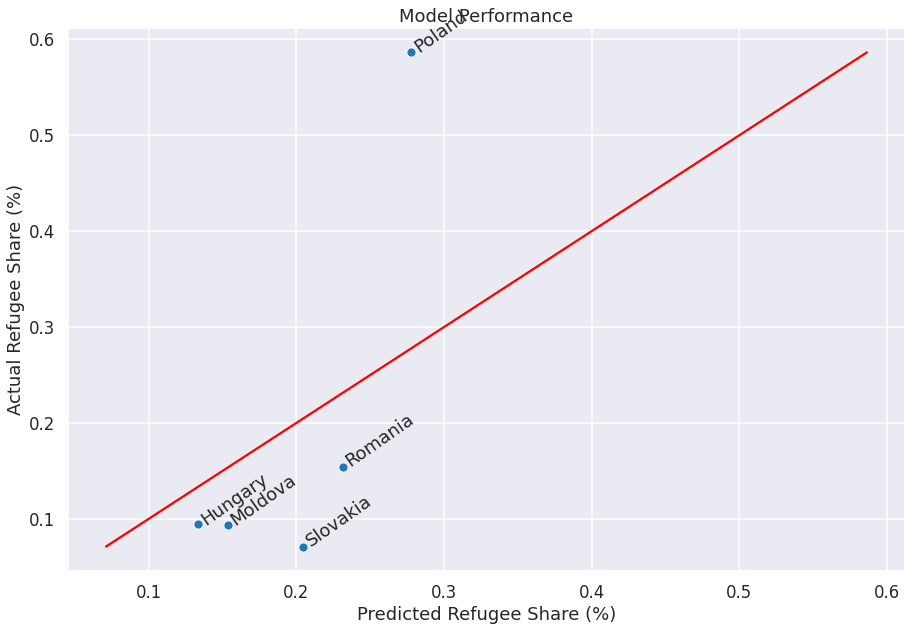

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x=shares, y=ukr_results['pct_tot'])
sns.lineplot(x=ukr_results['pct_tot'], y=ukr_results['pct_tot'], color='red')
ax.set_ylabel('Actual Refugee Share (%)')
ax.set_xlabel('Predicted Refugee Share (%)')
ax.set_title('Model Performance')
for i, label in enumerate(list(ukr_results['country'])):
    plt.annotate(label, (shares.iloc[i], ukr_results['pct_tot'].iloc[i]), rotation=35);

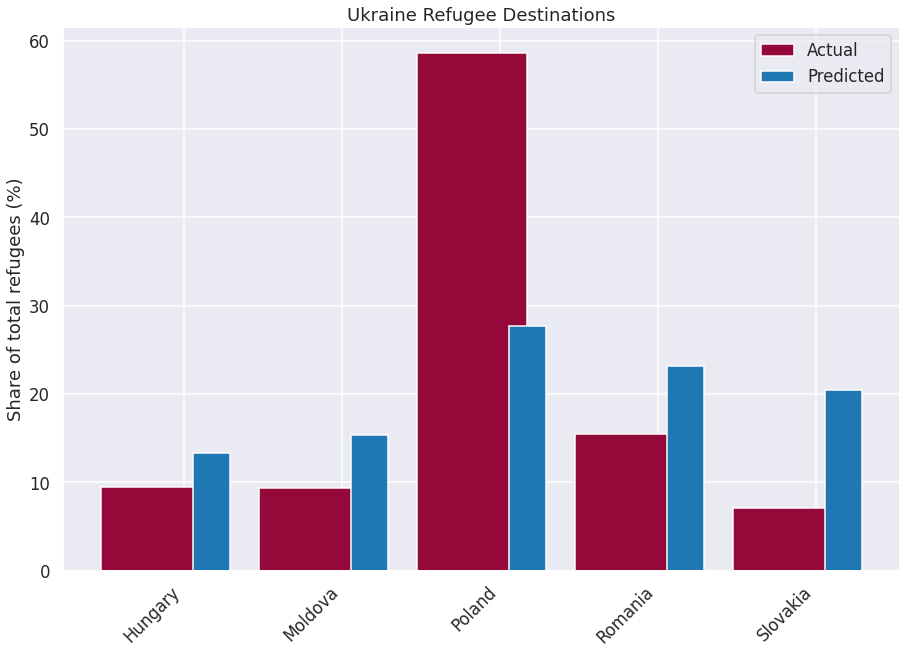

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))

width = .35

ax.bar(np.array(range(len(ukr_results['country']))) - width/2, ukr_results['pct_tot']*100, width*2, color='#94093a', label="Actual")
ax.bar(np.array(range(len(ukr_results['country']))) + width/2, ukr_results['predicted_shares']*100, width/3*2, label="Predicted")
ax.set_xticks(list(range(len(ukr_results['country']))))
ax.set_xticklabels(ukr_results['country'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend()

ax.set_ylabel('Share of total refugees (%)')
ax.set_title('Ukraine Refugee Destinations');